<a href="https://colab.research.google.com/github/NYU-IEP-2022-3-Classroom/lab4-data-repository-hs4563/blob/main/lab4_orbit_tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MODIFY THIS BLOCK
to contain the correct information for your experiments

In [1]:
!rm -rf /content/data/

# MODIFY THIS LINE SO THAT THE URL POINTS TO YOUR DATA REPOSITORY
!git clone https://github.com/NYU-IEP-2022-3-Classroom/lab4-data-repository-hs4563 data #change to your github user name - do not erase the "data" afterwards

#UPDATE THESE!
setupNumber = 42 #if you worked on different setups on different days, then enter the first setup, and make a note below
section = 0 # 1 = M, 2 = T AM, 3 = T PM, 4 = W 
date = "14-Nov-2021" #change to the date of the first day of your experiments
angleOfWall = 9999 #enter the angle of the major axis IN DEGREES according to your setup when the bob is swinging parallel to the wall
notes = "nothing to report" #any important notes other people should know

Cloning into 'data'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 103 (delta 11), reused 102 (delta 11), pack-reused 0
Receiving objects: 100% (103/103), 29.99 MiB | 20.86 MiB/s, done.
Resolving deltas: 100% (11/11), done.


#RUN THIS BLOCK ONCE
to set up the functions

In [2]:
#@title $\gets$ Run Me Once (I have the code setup and function definitions)

# necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import scipy.optimize
import itertools,operator
import copy
from sklearn.utils import Bunch
import json


#this line makes sure you followed the direction above; if you see 20 copies of "you didn't change the directory to match your name!" 
#that means you need to update the data repository name in the cell block above and again
if os.path.isdir('data/20221110154929'):
  for i in range(20):
    print ("You didn't change the directory to match your name!")

def findAngleFiles (startdir):
  #angleFiles = findAngleFiles(startdir)
  # input stardir: path to top level directory (e.g. data_repository/large bob)
  # output angleFiles: array with paths to angle files  
  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python

  angleFiles = sorted(glob.glob(startdir + '/**/*_angle.txt'))
  return (angleFiles)

# fitting an exponential
# exponential has two parameters, the y-intercept (a) and the
# exponential multiplier constant (b which for our purposes is -1/tau)
# uses cauchy loss function to reduce the influence of outliers
# inputs: x,y - numpy arrays
# outputs: a: fit value of y(0)
#          b: fit value of exonent
#          fity: a * e^(bx) 
def fitExponentialCauchyLoss(x,y):
  xx = x - np.min(x)
  yy = y / np.max(y)
  res = scipy.optimize.least_squares(lambda p : p[0]*np.exp(p[1] * xx)-yy,  (1, -1/max(xx)), loss = 'cauchy')
  a = res.x[0]
  b = res.x[1]
  a = a*np.max(y)*np.exp(-b*np.min(x))
  return (a,b, a*np.exp(b*x))

# load angle file and do some minor processing
# inputs: filepath - path of the file
# outputs: bunch object with fields
# number crossing number since start of experiment (a full period is 2 crossings)
# time time of crossing since start of experiment (resolution = 1us, accuracy unknown)
# majaxis major axis (in mm) from fitter
# minaxis minor axis (in mm) from fitter
# theta angle of major axis (in radians) relative to x-axis, from fitter
# slope slope of the voltage vs. time trace (in V/s) at time of crossing --  proportional to the total energy of the bob
# dnamplitude denoised amplitude (```sqrt(majaxis**2 + minaxis**2)```) (in mm)  found by fitting the amplitude to a decaying exponential using a cost-function that discards outliers
# dnmajaxis denoised major axis (see fit amplitude) (in mm)
# dnslope denoised slope (in V/s)
# filename name of the file the experiment was loaded from

def loadAngleFile(filepath, maxTime = 10000000):
  try:
    number, time, majaxis, minaxis, theta, slope = np.loadtxt(filepath, skiprows = 1, unpack = True)
    _,_,fitamplitude = fitExponentialCauchyLoss(time-time[0],np.sqrt(minaxis**2 + majaxis**2))
    _,_,fitmajaxis = fitExponentialCauchyLoss(time-time[0],majaxis)
    _,_,fitslope = fitExponentialCauchyLoss(time-time[0],slope)
    expt = Bunch(number=number-number[0],time=time-time[0],majaxis=majaxis,dnamplitude=fitamplitude,minaxis=minaxis,theta=np.unwrap(theta),slope=slope,dnmajaxis=fitmajaxis, dnslope=fitslope,filename=filepath, include = True)
  except:
    expt = Bunch(include = False)
  return expt
  #expt.include = np.mean(np.abs(majaxis*minaxis)) < 4000 and (theta[-1]-theta[0])  

def trimExperiment(oldexpt, timerange):
  expt = copy.copy(oldexpt)
  valid = np.logical_and(expt.time >= np.min(timerange), expt.time <= np.max(timerange))
  expt.time = expt.time[valid]
  expt.time = expt.time - expt.time[0]
  expt.number = expt.number[valid]
  expt.number = expt.number - expt.number[0]
  expt.majaxis = expt.majaxis[valid]
  expt.minaxis = expt.minaxis[valid]
  expt.theta = expt.theta[valid]
  expt.slope = expt.slope[valid] 
  _,_,expt.dnamplitude = fitExponentialCauchyLoss(expt.time,np.sqrt(expt.minaxis**2 + expt.majaxis**2))
  _,_,expt.dnmajaxis = fitExponentialCauchyLoss(expt.time,expt.majaxis)
  _,_,expt.dnslope = fitExponentialCauchyLoss(expt.time,expt.slope)
  return expt

def plotAndSortAngleFiles(expt):
  for e,i in zip(expt,range(len(expt))):
    if (not(e.include)):
      continue
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.plot(e.time,e.minaxis,'C0')
    ax1a = ax1.twinx()
    ax1a.plot(e.time,e.majaxis,'C1')
    ax1.set_ylabel('minor axis', color='C0')
    ax1.tick_params(axis='y', color='C0', labelcolor='C0')
    ax1a.set_ylabel('major axis', color='C1')
    ax1a.tick_params(axis='y', color='C1', labelcolor='C1')
    ax1.set_xlabel('time (s)')  
    ax2.plot(e.time, 180/np.pi*e.theta)
    ax2.set_xlabel('time(s)')
    ax2.set_ylabel('maj axis anlge (deg)')
    e.include = np.mean(np.abs(e.majaxis*e.minaxis)) < 4000 and np.abs((e.theta[-1]-e.theta[0])/(e.time[-1]-e.time[0])) < 1000*(np.pi/180)/3600
    _,name = os.path.split(e.filename)
    ax1.set_title ('expt {}: {}'.format(i,name))
    if e.include:
      ax2.set_title ('to be included')
    else:
      ax2.set_title('to be excluded')
    fig.tight_layout()
    fig.show()


#Run this block of code whenever you add data to the github repository

to verify the data is loading correctly and you can access it

Already up to date.
found 12 data files
loaded 12 data files


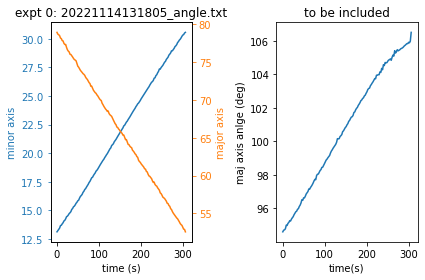

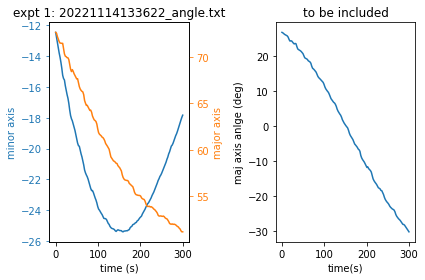

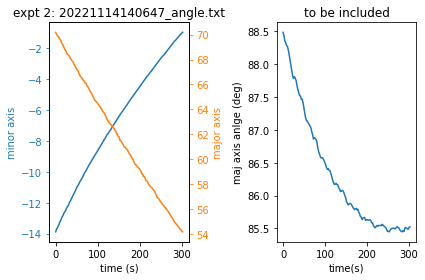

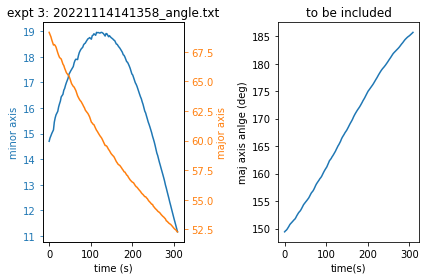

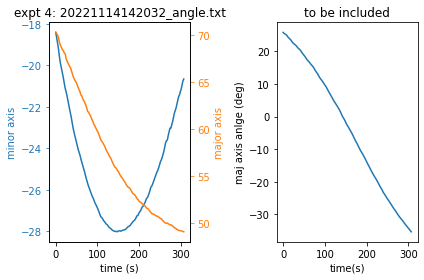

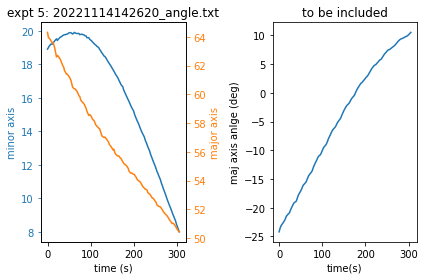

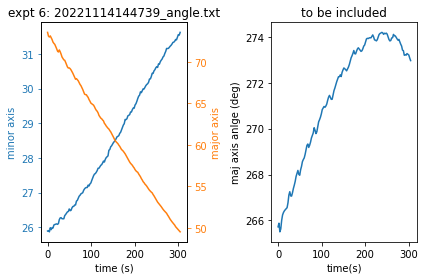

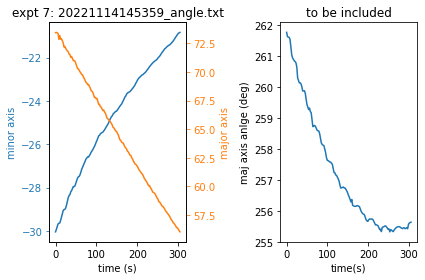

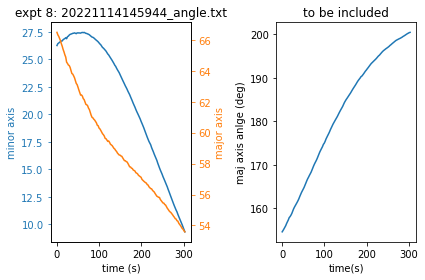

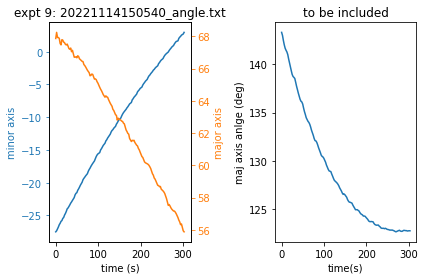

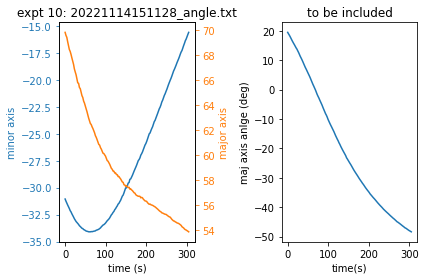

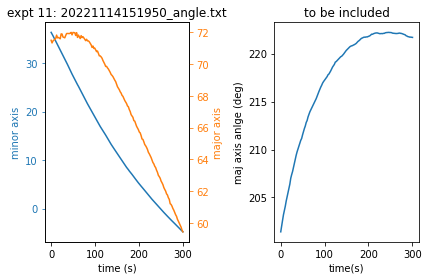

In [3]:
#@title $\gets$ Run Me whenever you update your git repository

!git -C /content/data/ pull

startdir = '/content/data'

angleFiles = findAngleFiles(startdir)
print('found {} data files'.format(len(angleFiles)))
expt = [loadAngleFile(af) for af in angleFiles]
print('loaded {} data files'.format(len(angleFiles)))

plotAndSortAngleFiles(expt)

if os.path.isdir('data/20221110154929'):
  for i in range(20):
    print ("instructor sample data used - rerun first cell with your information!")



#Trim or exclude the experiments if needed

If an experiment is bad (i.e. you didn't mean to hit record or Phil bumped the table, or whatever, but you accidentally included it in the git repository), set `expt[that experiment].include = False`

e.g. if experiments 0 and 4 were mistakes, you'd write
```
expt[0].include = False
expt[4].include = False
```

Above, we automatically excluded data sets with extreme axes values (major * minor axes > 4000 mm^2) or extreme measured rotation rates (>1,000 deg / hr), because these probably reflect errors in the fitter; if you have a data set that actually contains such extreme values and want it included, then you can set `expt[that experiment].include = True`

If a data set is good, but has problematic elements at the beginning or the end (e.g. the amplitude got small enough at the end that the detector started missing crossings), you can use `expt[that experiment] = trimExperiment(expt[that experiment], timerange)`

e.g. if experiment 0 was initially 310 seconds long, to discard the first and last 10 seconds (use 10 to 300), you would type

```
expt[0] = trimExperiment(expt[0],(10,300))
```



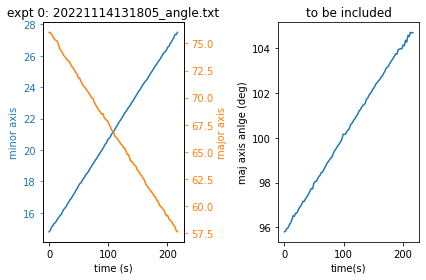

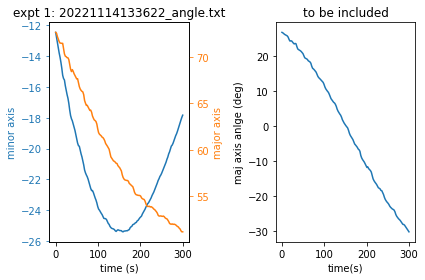

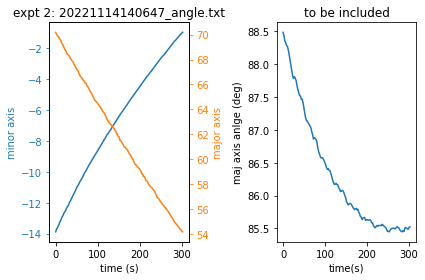

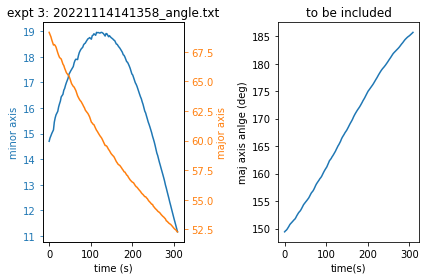

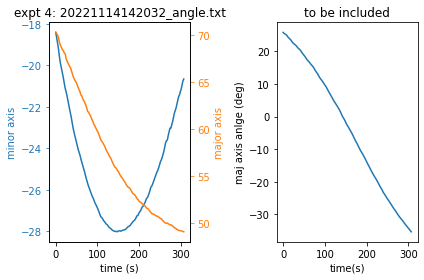

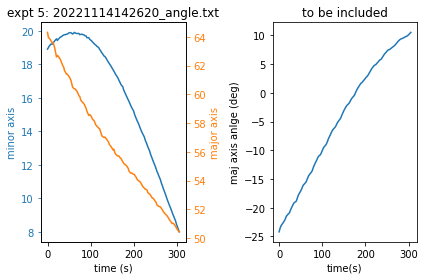

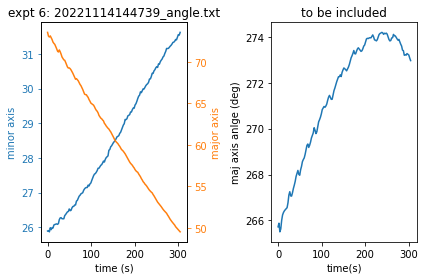

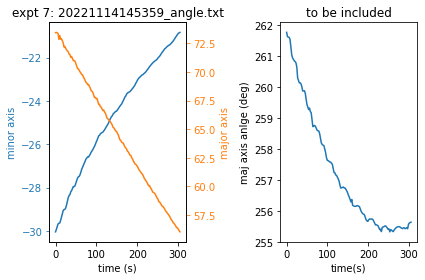

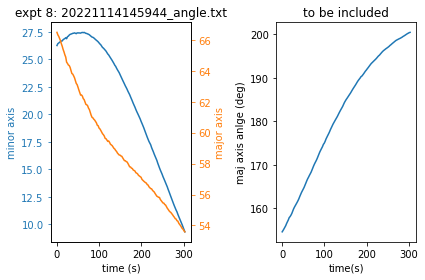

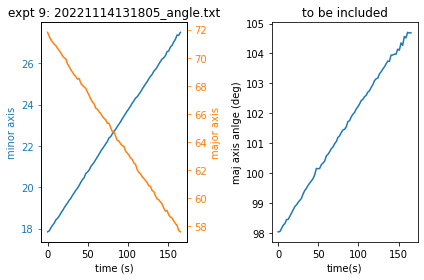

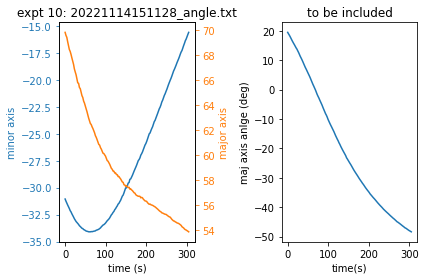

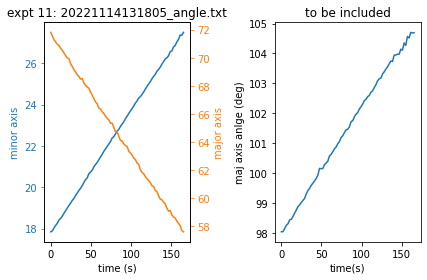

In [6]:
#do any trimming or excluding here
expt[0] = trimExperiment(expt[0],(10,250))
expt[9] = trimExperiment(expt[0],(50,300))
expt[11] = trimExperiment(expt[0],(50,300))

#plot the trimmed and included experiments again, to make sure things look good
plotAndSortAngleFiles(expt)

## Run this block to save your data to a json file
This stores the experimental parameters you entered and the trimmed data files to a single text file in json format. 

**you should copy this file to your individual github repository AND to the shared class repository**

1. open the file explorer to the left, click on the dots next to the file name and download to the local computer
2. copy the file into the local github repository location, then use github desktop to sync OR use the web interface to upload directly
3. use the web interface to upload the same file to the class repository - don't forget to enter a commit message and save. Note that your commit messages will be publicly visible to the world, so don't include your name or any naughty words.



In [7]:
fits = []
for e in expt:
  if (not(e.include)):
    continue
  fits.append({"filename":e.filename, "number":e.number.tolist(), "time":e.time.tolist(), "majaxis":e.majaxis.tolist(), "minaxis":e.minaxis.tolist(), 
               "theta":e.theta.tolist(), "slope":e.slope.tolist()})
               
results = {"setupNumber":setupNumber, "section":section, "thetaWall":angleOfWall, "notes":notes, "fits":fits}
outputname = 'section{:d}setup{:d}-{}.json'.format(int(section), int(setupNumber), date)
file = open(outputname, 'w')
json.dump(results, file)
file.close()

print('data saved in {} - BE SURE TO COPY TO YOUR GITHUB'.format(outputname))

data saved in section0setup42-14-Nov-2021.json - BE SURE TO COPY TO YOUR GITHUB
